# Biofysikk - Prosjekt
# Introduksjon til vitenskapelige beregninger
# Våren 2022

## Introduksjon 
I dette prosjektet skal vi se på hvordan systemer av monomerer og systemer av polymerer tidsutvikles. For dette skal vi benytte oss av Monte-Carlo algoritmen, nærmere bestemt *Metropolis algoritmen*. Monte-Carlo er en mye brukt metode for å simulere mønster i kaos. Den anvendes blant annet i værprediksjon, astrofysikk og smittemodelleringen i Norge, grunnet dens simpelhet, elegans og skalerbarhet. Hver iterasjon vil ha en sansynlighetsfordeling som kun er avhengig av den forrige iterasjonen. I det lange løp vil simulasjonen  konvergere mot det mest sannsynlig utfallet.

## Oppgave 1

Oppgave 1 handler om systemer av monomerer. Et monomer er her et molekyl som kan ha ladningen +1 eller -1 (dimensjonsløs). Her skal vi simulere utviklingen av systemer med tilfeldig plasserte monomerer. Programmeringsmessig er det vanskelig å beskrive kontinuerlige intervaller, og vi løser dette med å diskretisere rommet monomerene befinner seg i. I tillegg senker vi kompleksiteten ved å anta at monomerene befinner seg i et 2-dimensjonelt rom. Vi modellerer altså punkter med konstant avstand (23 µm) imellom seg. Vi kan beskrive hvert punkt med en rad, en kolonne, og en monomerverdi (en unik verdi tildelt hvert monomer, 0 dersom punktet ikke inneholder et monomer).

Etter vi har tilfeldig plassert ønsket antall monomerer itererer vi gjennom dem, og flytter dem til en tilfeldig, tom nabo-posisjon. Sannsynlighetsfordelingen er avhengig av monomerets naboer og temperaturen. Det elektriske potensialet minimeres når monomerer av motsatt ladning kommer i kontakt, og øker dersom de skulle gått fra hverandre igjen. Programmet vil ha en høyere sannsynlighet for å minimere energien/potensialet. Temperaturavhengigheten skyldes termiske fluktuasjoner som noen ganger kan føre til energimessige *ugunstige* endringer. Det er derfor implentert en temperatur-proposjonal sannsynlighet for at et trekk ikke er energiminimerende.

### Importering av diverse biblioteker og definering av konstanter

In [1]:
# Numerisk python bibliotek
import numpy as np
from numpy.random import randint
from numpy.random import uniform

# Brukes til å finne antall clusters. Se funk<monomer_to_clusters>
from scipy.ndimage.measurements import label

# Matplotlib for plotting og colormesh
from matplotlib.colors import from_levels_and_colors
import matplotlib.pyplot as plt

# Numba for å minimere kjørtid
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
 
# Fjerner Numba advarsler
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)


#Konstanter
e_r = 78                           #Relativ permitivitet
e_0 = 8.854187812813e-12           #Vakum permitivitet
a   = 23e-6                        #23µm mellom grid-points
k_b = 1.38064852e-23               #Boltzmans konstant
e = 1.60217662e-19                 #ladning til ett elektron

alpha = e**2/(4*np.pi*e_0*e_r*a**2)

 ### Oppgave 1a: Initialisering tilfeldig grid

In [2]:
@jit(nopython=True)
def create_grid(N, M):
    '''
    Generates a NxN grid with 2M randomly 
    placed monomers of charge -1 or 1 
    (M of each charge).
    N: grid size
    M: number of monomers to be placed
    '''
    grid = np.zeros((N,N), dtype=np.dtype('i2'))         # Generates a NxN grid with all elements equal to zero and datatype int (for faster runtime)
    positive_monomers = 0                                # Number of positive monomers in the grid
    negative_monomers = 0                                # Number of negative monomers in the grid
    while (positive_monomers<M or negative_monomers<M):  # Iterates until all monomers are placed
        # Generates random points
        x = randint(0,N)
        y = randint(0,N)

        # Places monomer in empty cell (in solution)
        if (grid[x,y] == 0 and positive_monomers < M):
            positive_monomers += 1
            grid[x,y] = 1*positive_monomers               # Gives assigned value to every monomer

            
        elif (grid[x,y] == 0 and negative_monomers < M):
            negative_monomers += 1
            grid[x,y] = -1*negative_monomers
             
    return grid

test_grid = create_grid(15,25)

### Oppgave 1b: Visualisering av grid vha pcolormesh

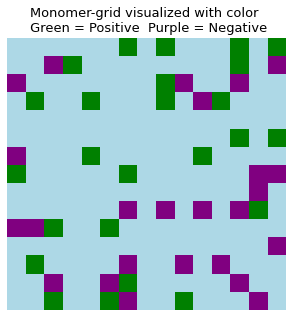

In [3]:
def colormesh_grid(grid):
    '''
    Simply plots a grid of monomers with color determining the
    qualitative charge of the monomers
    '''    
    levels = [-100,0,1,100]
    colors = ["purple","lightblue","green"]
    cmap, norm = from_levels_and_colors(levels,colors)
    
    plt.figure(figsize= (5,5))
    plt.pcolormesh(grid[::-1,], cmap = cmap, norm = norm)
    plt.axis("off")
    plt.title("Monomer-grid visualized with color \n Green = Positive  Purple = Negative", size=13)
    
    return None

colormesh_grid(test_grid)

### Oppgave 1c: Nærmeste nabo og funksjon for monomer flytt

In [4]:
@jit(nopython=True)
def get_neighbors_coordinates(N,i,j):
    '''
    Returns the neighboring points to the input point in a NxN grid
    with 'donut' boundary (see picture))
    N: size of grid
    i: row ([0, N-1])
    j: column
    '''
    
    NN = np.zeros((4,2), dtype = np.dtype('i2')) #NN = Nearest Neighbor
    NN[0] = [i,j-1] # Left: 0
    NN[1] = [i,j+1] # Right: 1
    NN[2] = [i-1,j] # Up: 2
    NN[3] = [i+1,j] # Down: 3
    
    if (j+1==N):
        NN[1]=[i,0]

    if (i+1==N):
        NN[3]=[0,j]

    return NN

In [5]:
#Retningsindeksering: 0 = venstre, 1 = høyre, 2 = opp, 3 = ned
#OBS: Kode lånt fra  "Kom-i-gang notet (jupyter)"
#     se <https://wiki.math.ntnu.no/tma4320/2022v/ovinger>
@jit(nopython=True)
def move_monomer(grid, monomer_value, direction):
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] 

    N = grid.shape[0]
    
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]
    
    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value # moving the monomer
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0 #replacing old position of the monomer with solvent


### Oppgave 1d: System energi for monomer-system

In [6]:
@jit(nopython=True)
def total_energy(grid):
    E = 0
    N = np.shape(grid)[0]                         #Størrelse på grid
    
    #Ittererer gjennom hvert punkt på grid
    for i in range(N):                            #Rad
        for j in range(N):                        #Kolonne
            NN = get_neighbors_coordinates(N,i,j) #Finner alle naboer
            rad, kolonne = NN[:,0],NN[:,1]        #Splitter array fra NN i to
            
            a = grid[i,j]                         #Verdi i grid-punkt
            for x in range(4):                    #Ittererer gjennom hver nabo
                b = grid[rad[x]][kolonne[x]]      #Verdi for nabo
                if (a == 0 or b==0):              #Sjekker om valgt punkt eller nabo har verdi 0
                    E = E
                elif (np.sign(a) != np.sign(b)):  #Dersom det er ulik ladning:
                    E = E - alpha                 #Energi = Tidligere utregnet energi + w_k w_l alpha
                                                  # hvor w_k w_l = -1
                elif (np.sign(a) == np.sign(b)):  #Dersom det er lik ladning:
                    E = E + alpha                 #Energi = Tidligere utregnet energi + w_k w_l alpha
                                                  # hvor w_k w_l = +1
    
    #For å kompansere for overtelling så deles energien på 2
    #Dette skyldes at en monomer a som reagerer med b telles både interaksjonen a->b og b->a
    
    return E/2 
print("Energien for systemet plottet i 1b er: ",total_energy(test_grid)," Joule.")

Energien for systemet plottet i 1b er:  -6.709546348754814e-20  Joule.


### Oppgave 1e: Monte Carlo algoritme for monomer-system

In [7]:
@jit(nopython=True)
def Monte_Carlo(Ns, N, M, T,grid):
    E0 = total_energy(grid)
    grid_old = grid.copy()                                #Lager to kopier av input array
    grid_new = grid.copy()                                #Dette gjør at man beholder forrige mens
                                                          #det andre testes endringer på
    energi = np.zeros(Ns+1,dtype=np.dtype('f'))           #Array for system energi
    energi[0] = E0
    
    for i in range(Ns):                                   #Regner både lovlige og ulovlige flytt som en itterasjon
        direction = randint(0,4)
        magnitude = randint(1, M + 1)
        sign = 2 * randint(0, 2) - 1
        move_monomer(grid_new, sign*magnitude, direction) #Gjør et tilfeldig flytt av en tilfeldig monomer
        
        if (grid_old==grid_new).all() == False:           #Sjekker om det er gjort endring på grid
            E = total_energy(grid_new)
            dE = E-E0
            p = uniform(0,1)
            beta = 1/(k_b*T)
            if (dE<0):                                     #Systemet ønsker å oppnå et lavere energinivå
                grid_old = grid_new.copy()
                energi[i+1] = E
                E0 = total_energy(grid_old)
            elif(p < np.e**(-beta*dE)):                    #Termisk fluktuering i system kan realisere et energi ugunstig flytt
                    grid_old = grid_new.copy()
                    energi[i+1] = E
                    E0 = total_energy(grid_old)                    
            else:                                          #Beholder det gamle grid'et dersom det var en usannsynlig endring
                energi[i+1] = energi[i]
                grid_new = grid_old.copy()
        else:
            energi[i+1] = energi[i]
    return grid_new, energi

### Oppgave 1f: Første Monte Carlo simulering

In [8]:
#Simulasjonsparamtre og grid
Ns = 50000                      #Antall simulasjoner
N  = 15                         #Størrelse på grid
M  = 25                         #Antall positive/negative monomerer, totalt 2M
T1 = 200                        #Temperatur for simulasjon 1
T2 = 500                        #Temperatur for simulasjon 2
grid = create_grid(N,M)         #Lager grid som kan brukes i begge simulasjoner

In [9]:
grid_T1, energi_T1 = Monte_Carlo(Ns, N, M, T1,grid)
grid_T2, energi_T2 = Monte_Carlo(Ns, N, M, T2,grid)

#Lagrer grid som npz fil av grid for lav temperatur, kan senere aksesseres
np.savez("sim.npz", temp_lav = grid_T1)               

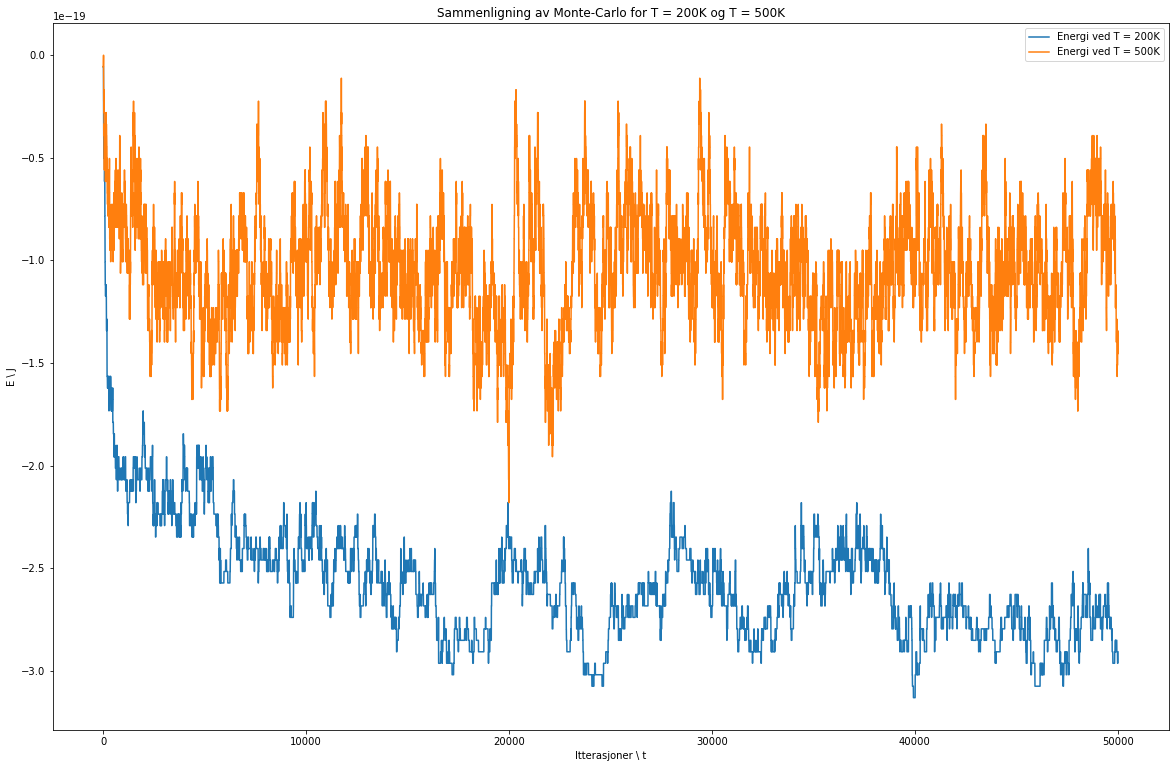

In [10]:
#Plott av energi-verdier gjennom MC-algoritmen
t = np.linspace(0,Ns,Ns+1)                                        

plt.figure(figsize=(20,13))

plt.title("Sammenligning av Monte-Carlo for T = 200K og T = 500K")
plt.xlabel("Itterasjoner \ t")
plt.ylabel("E \ J")

plt.plot(t,energi_T1,label = "Energi ved T = 200K")
plt.plot(t,energi_T2,label = "Energi ved T = 500K")

plt.legend()
plt.show()

### Drøfting av resultater
I plottet over ser vi hvordan temperatur påvirker energiutviklingen til et monomersystem i løpet av 50000 iterasjoner.
	
Ved høy temperatur (500K) oppnås det likevekt i løpet av høyst 5000 iterasjoner på rundt -1*e-19 J (se figur). Årsaken til den raske konvergensen i varme omgivelser kommer av at forskjellen mellom termisk energi og elektrisk energi vil være mindre, så løsrivelse fra en ellers stabil posisjon vil inntreffe oftere enn for lavere temperaturer (se oppgavebeskrivelse øverst). Dette medfører at monomerene vil bevege seg mer enn for et kjøligere system, som igjen lar systemet finne en mer stabil energitilstand raskere. Dette medfører også høyere energifluktueringer eller "usikkerhet" som vi ser tydelig fra figuren.
	
For lavere temperatur (200K) bruker systemet (ca) 15000 iterasjoner på å oppnå sin likevekt på rundt 
-2.7*e-19 J (se figur). Ved lavere temperaturer vil monomerene løsrives sjeldnere på grunn av termisk energi. Monomerene vil derfor ikke bevege seg like ofte som for varmere systemer fordi de for det meste bare kan bevege seg mot energigradienten. Ved at monomerene ikke beveger seg like ofte vil systemet også bruke lengere tid på å oppnå likevekt.
	
Våre data av energi og antall iterasjoner ved likevekt vil variere fra simulasjon til simulasjon. Men tendensen om at varmere systemer oppnår likevekt kjappere enn for kaldere systemer vil være likt for alle.


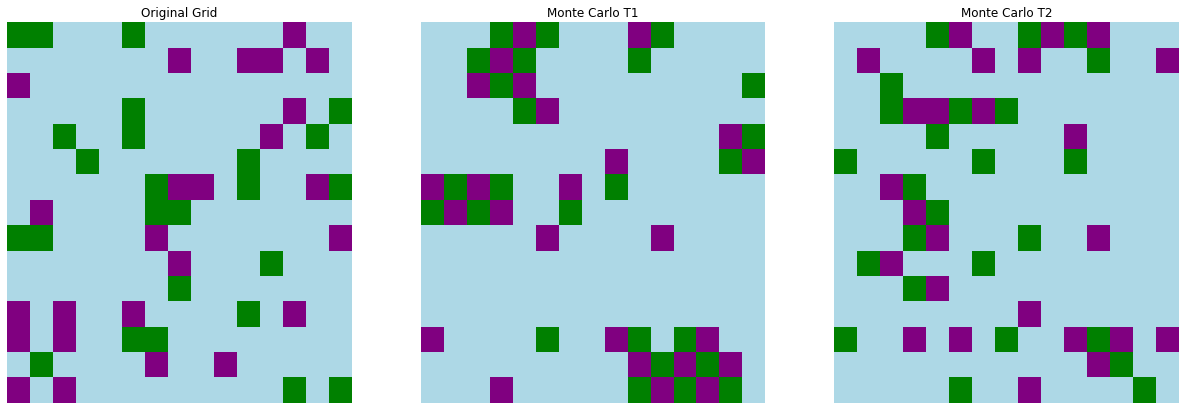

In [11]:
#Bonus
#Sammenligner de to ulike systemene for MonteCarlo simulasjon av samme grid
f = plt.figure(figsize=(21,7))
ax_original = f.add_subplot(131)
ax_T1 = f.add_subplot(132)
ax_T2 = f.add_subplot(133)

levels = [-100,0,1,100]
colors = ["purple","lightblue","green"]
cmap, norm = from_levels_and_colors(levels,colors)

ax_original.axis('off')
ax_T1.axis('off')
ax_T2.axis('off')

ax_original.set_title("Original Grid")
ax_T1.set_title("Monte Carlo T1")
ax_T2.set_title("Monte Carlo T2")

ax_original.pcolormesh(grid[::-1],cmap = cmap,norm = norm)
ax_T1.pcolormesh(grid_T1[::-1],cmap = cmap,norm = norm)
ax_T2.pcolormesh(grid_T2[::-1],cmap = cmap,norm = norm)

### Oppgave 1g: Clustering av monomer-system

In [12]:
def colormesh_combined(monomer_grid,cluster_grid):
    #Plotter monomer og cluster grid side om side
    f = plt.figure(figsize=(20,10))
    
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    levels = [-10000,0,1,10000]
    colors = ["purple","lightblue","green"]
    cmap1, norm1 = from_levels_and_colors(levels,colors)
    
    ax.axis('off')
    ax2.axis('off')
    ax.set_title("Monomersystem \n Grønn = Positiv   Lilla = Negativ",fontsize = 25)
    ax2.set_title("Clustersystem \n Ulik farge for ulik cluster", fontsize = 25)
    ax.pcolormesh(monomer_grid[::-1],cmap = cmap1,norm = norm1)
    ax2.pcolormesh(cluster_grid[::-1],vmin = -1,cmap = 'tab20_r')

In [13]:
def monomer_to_cluster(grid):
    grid_copy = grid.copy()
    labeled, num_labels = label(grid_copy) # (se importering)
    
    N = np.shape(grid_copy)[0]
    
    #Kontakt mellom topp og bunn
    for x in range(N):
        pot_monomer = labeled[0,x]
        kontakt_pot_monomer = labeled[-1,x]
        if ( pot_monomer != 0 and kontakt_pot_monomer != 0): #Dette vil bety at en monomer er i kontakt med en annen
            arg = np.argwhere(labeled == kontakt_pot_monomer)
            for j in arg:
                labeled[j[0],j[1]] = pot_monomer
                
    #Kontakt mellom venstre og høyre vegg
    for y in range(N):
        pot_monomer = labeled[y,0]
        kontakt_pot_monomer = labeled[y,-1]
        if ( pot_monomer != 0 and kontakt_pot_monomer != 0):
                arg = np.argwhere(labeled == kontakt_pot_monomer)
                for j in arg:
                    labeled[j[0],j[1]] = pot_monomer
    return labeled

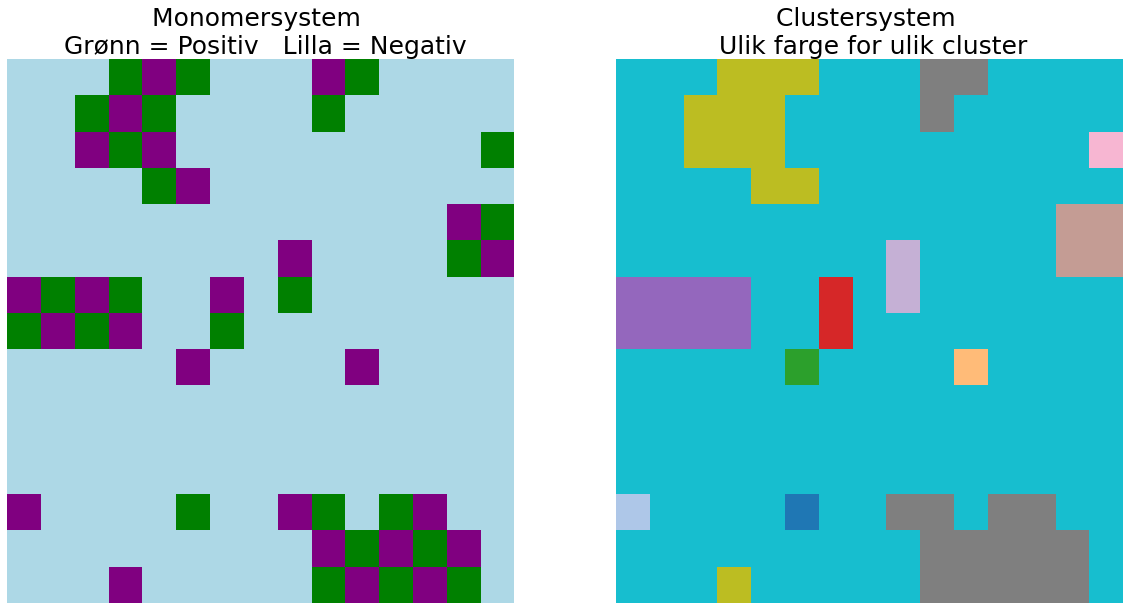

In [14]:
monomer_fra_sim = np.load("sim.npz")['temp_lav']      #Henter simulasjons grid fra 1f
cluster_fra_sim = monomer_to_cluster(monomer_fra_sim) #Omgjør til cluster_grid
colormesh_combined(monomer_fra_sim,cluster_fra_sim)   #Bruker funksjonen colormesh_combined til å sammenligne disse to

### Oppgave 1h: Stor-skala Monte Carlo simulering
#### Forventningsverdi av cluster størrelse
Monte Carlo simulasjon vil etter mange iterasjoner føre systemet mot en sannsynlig tilstand. Gjennomsnittet av mange slike simulasjoner vil, ifølge loven om store tall, konvergere mot forventningsverdien til systemetilstanden.

In [15]:
def number_of_clusters(cluster_grid):
    N = np.shape(cluster_grid)[0]
    set1 = {0}
    
    #Lager sett av unike tall i cluster grid
    for i in range(N):
        set_temp = set(cluster_grid[i])
        set2 = set.union(set_temp,set1)
        set1 = set2.copy()
    set1.remove(0)                                 #Fjerner 0 verdi, da dette er løsningen og ikke en monomer.
    
    return len(set1)                               #Antall unike elementer vil da være antall cluster


In [45]:
#Simulasjons parametre
N = 15
M = 25

T_l = 100
T_u = 1000
t_max = 100000
s = 1/200
C = 10000
t_r = 1000
n = 10



T = np.linspace(T_l,T_u,10)                 # Simulerer for 10 ulike temperaturer
t_equil = t_max*np.e**(-s*(T-T_l))+C

In [46]:
def simulasjon():
    d = np.zeros(10,dtype=np.dtype('f'))                                            #10 ulike temperaturer
    for i in range(10):
        grids = np.zeros(N)
        grid = create_grid(N,M)
        grid_new = Monte_Carlo(int(t_equil[i]),15,25,int(T[i]),grid)[0].copy()      #Grid i amtatt equil
        
        cluster_grid = monomer_to_cluster(grid_new).copy()
        m_grid = number_of_clusters(cluster_grid)
        temp_d = 2*M/m_grid                                                         #Vil alltid være 2*M monomerer
        for j in range(1,n+1):                                                      #n målinger etter antatt likevekt
            grid_new =  Monte_Carlo(t_r,15,25,int(T[i]),grid_new)[0].copy()
            cluster_grid = monomer_to_cluster(grid_new).copy()
            m_grid = number_of_clusters(cluster_grid)
            temp_d = temp_d + 2*M/m_grid
        d[i] = temp_d/(n+1)                                                         #Gjennomsnittlig d etter de n+1 målingene

    return d

In [47]:
# To simulasjoner
d_1 = simulasjon()
d_2 = simulasjon()

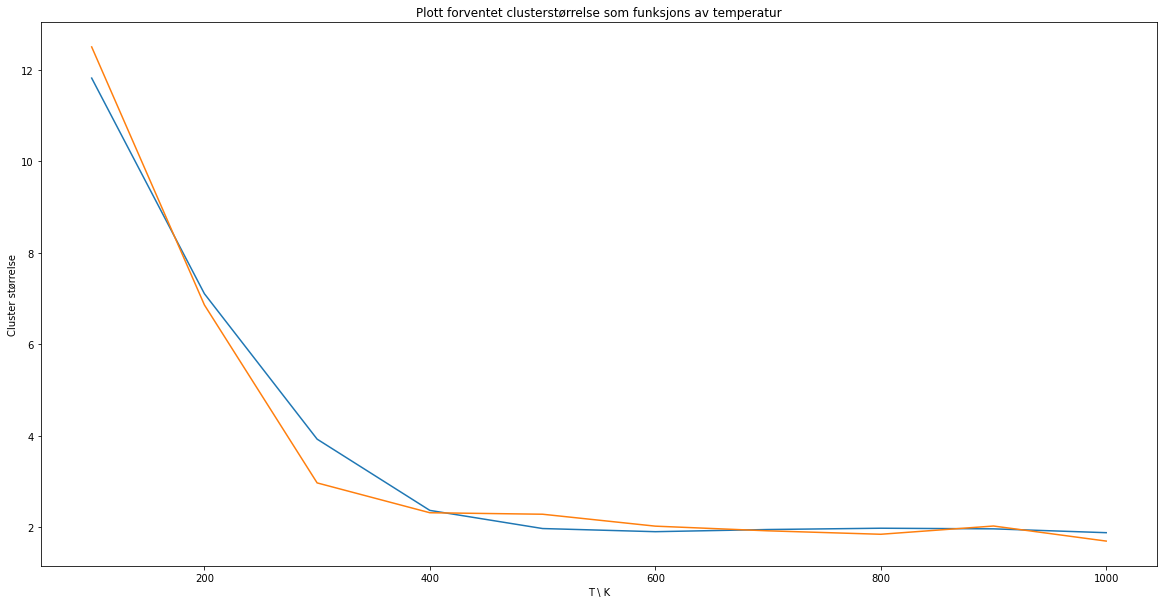

In [48]:
#Plotting av forventet cluster størrelse som funksjon av temperatur
plt.figure(figsize = (20,10))

plt.title("Plott forventet clusterstørrelse som funksjons av temperatur")
plt.xlabel("T \ K")
plt.ylabel("Cluster størrelse")

plt.plot(T,d_1)
plt.plot(T,d_2)

plt.show()

### Drøfting av resultater

Grafen over viser forventet clusterstørrelse som en funksjon av temperatur. Ved lavere temperaturer er termisk fluktuasjon svært usannsynlig. Det vil si at når man får clusterdannelser, er det sannsynlig at monomerer vil fortsette å bygge på disse, med mindre de finner en annen "partner". For systemer ved høyere temperatur, så er termisk fluktuasjon mye mer realiserbart. Dette gjør at selv om mange monomerer har dannet et stort og fint cluster, så er det ikke usannsynlig at man spalter av monomerer. Dette gjør at man vil oppleve å få mange flere clusters, og med det vil clusterstørrelsen avta da den er omvendt proposjonal med antallet clusters.

Det som overasker oss med resultatene er hvor fort kurven flater ut. Allerede ved 400K ser kurven svært flat ut. Dette henger sannsynligvis sammen med økningen på eksponensial funksjonen vi har i MC-algoritmen. Denne vil nok være betraktelig høyere ved for eksempel ved 200K, men sannsynligvis ikke svært forskjellig for de høyere temperaturene. Dette kan man forøvrig også se ved å plotte exp(-1/x). Man ser at denne stiger svært bratt i starten, men flater raskt ut og konvergerer mot 1. Dette er trolig samme årsak til at avviket er større ved lavere temperaturer.

Vi kjørte to like simulasjoner for ulike grids for å se om det var rene tilfeldigheter, men ut ifra hvordan de to ulike kurvene ser ut, er det ikke urimelig å anta at dette ikke var tilfeldig.
    

## Oppgave 2
I oppgave 2 skal vi utvide horisonten til å også se på polymer-systemer. Det er ikke store endringer fra oppgave 1 annet enn at vi må gjøre noen enkle tilpasninger, og innføre hvordan en polymer kan flytte seg. Vi kommer til å innføre to typer flytt, rigid og medium flex.

Polymersystemene er svært like monomersystemene, men vi bruker nå at flere monomerer med samme ladning kan henge sammen. Dette gir clusters av monomerer hvor vi indekserer lik verdi for alle monomerene i polymeret.

Rigid move er et flytt som ikke kan deformere polymeren. Det vil si at plass er svært essensielt, da det er begrenset hvor stort ledig rom det er rundt en polymer. Medium flex move er et flytt som tar hensyn til hindringer. Rader eller kolonner som kan flyttes ett flytt uten hindring gjør dette, mens rader eller kolonner som ikke kan dette, gjør det ikke. For å unngå at polymeret ødelegges blir det og implementert en funksjon som sjekker om vi har brutt polymerkjeden.

I tillegg må vi endre litt på energifunksjonen. Vi antar her at monomerer innad i en polymer ikke interagerer med hverandre. Dette er en rimelig antagelse, da polymeret ville gått i oppløsning ellers.

### Endring av konstant(er)
Distansen mellom hvert monomer endres fra 23µm til 91µm

In [20]:
a = 91e-6                           #91µm mellom hvert monomer
alpha = e**2/(4*np.pi*e_0*e_r*a**2)

### Oppgave 2a: Initialisering av polymer-system

In [22]:
# Basert på algoritme 1 i prosjektbeskrivelse
def create_grid_multivalency(N,M,L):
    grid = np.zeros((N,N),dtype=np.dtype('i2'))
    
    #For positive polymerer
    i = 0
    while i < M:
        # Generates random point
        x = randint(0,N)
        y = randint(0,N)
        
        if grid[x,y] != 0:
            continue
        else:
            grid[x,y] = i+1
            L_array = np.zeros((2,L),dtype = np.dtype('i2'))
            L_array[0][0] = x
            L_array[1][0] = y
            j = 1
            while j<L:
                a = randint(0,j)
                direction = randint(0,4)
                x , y = L_array[0][a],L_array[1][a]
                x_try,y_try = get_neighbors_coordinates(N,x,y)[direction]
                
                if grid[x_try,y_try] == 0:
                    grid[x_try,y_try] = i+1
                    L_array[0][j] = x_try
                    L_array[1][j] = y_try
                    j += 1
            i+=1
            
    #For negative polymerer
    k = 0
    while k<M:
        x = randint(0,N)
        y = randint(0,N)
        
        if grid[x,y] != 0:
            continue
        else:
            grid[x,y] = -1*(k+1)
            L_array = np.zeros((2,L),dtype = np.dtype('i2'))
            L_array[0][0] = x
            L_array[1][0] = y
            l = 1
            while l<L:
                a = randint(0,l)
                direction = randint(0,4)
                x , y = L_array[0][a],L_array[1][a]
                x_try,y_try = get_neighbors_coordinates(N,x,y)[direction]
                
                if grid[x_try,y_try] == 0:
                    grid[x_try,y_try] = -1*(k+1)
                    L_array[0][l] = x_try
                    L_array[1][l] = y_try
                    l += 1
            k+=1
    return grid

In [23]:
N = 20
M = 3
L = 25
test_grid_poly = create_grid_multivalency(N,M,L)

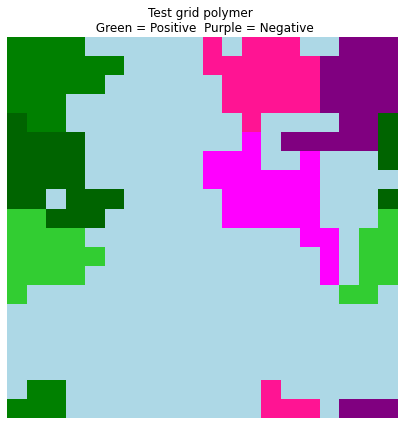

In [24]:
# Plot for polymer
f = plt.figure(figsize=(7,7))
#M = 3 --> 7 farger
levels = [-3,-2,-1,0,1,2,3,10]
colors = ["purple","magenta","deeppink","lightblue","darkgreen","limegreen","green"]
cmap1, norm1 = from_levels_and_colors(levels,colors)
    
plt.title("Test grid polymer \n Green = Positive  Purple = Negative")
plt.axis('off')
plt.pcolormesh(test_grid_poly[::-1],cmap = cmap1,norm = norm1)


### Oppgave 2b: System energi for polymer-system

In [25]:
@jit(nopython = True)
def total_energy_mult(grid):
    E = 0
    N = np.shape(grid)[0]
    #Ittererer gjennom hvert punkt
    for i in range(N):                                #Rad
        for j in range(N):                            #Kolonne
            NN = get_neighbors_coordinates(N,i,j)
            rad, kolonne = NN[:,0],NN[:,1]
            
            a = grid[i,j]  
            for x in range(4):
                if a != grid[rad[x],kolonne[x]]:      #unngår å kalkulere innad i polymeren
                    b = grid[rad[x],kolonne[x]]       #Verdi for nabo
                    if a == 0 or b==0:                #Sjekker om valgt punkt eller nabo har verdi 0
                        E = E
                    elif np.sign(a) != np.sign(b):    #Dersom det er ulik ladning:
                        E = E - alpha                 #Energi = Tidligere utregnet energi + w_k w_l alpha
                                                      # hvor w_k w_l = -1
                    elif (np.sign(a) == np.sign(b)):  #Dersom det er lik ladning:
                        E = E + alpha                 #Energi = Tidligere utregnet energi + w_k w_l alpha
                                                      # hvor w_k w_l = +1
    
    #For å kompansere for overtelling så deles energien på 2
    #Dette skyldes at en polymer a som reagerer med b telles både interaksjonen a->b og b->a
    return E/2

### Oppgave 2c: Implementasjon av Rigid-Move

In [26]:
@jit(nopython = True)
def rigid_move(grid,direction,polymer_value):
    N = np.shape(grid)[0]
    grid_new = grid.copy()
    grid_without_polymer = grid.copy()
    polymer_position = np.argwhere(grid == polymer_value)
    for i in range(len(polymer_position)):
        
        grid_without_polymer[polymer_position[i][0],polymer_position[i][1]] = 0
    
    for i in range(len(polymer_position)):
        x,y = polymer_position[i]
        x_try,y_try = get_neighbors_coordinates(N,x,y)[direction]

        if grid_without_polymer[x_try,y_try] == 0:
            grid_without_polymer[x_try,y_try] = polymer_value
        else:
            return grid
    return grid_without_polymer

### Oppgave 2d: Monte Carlo-algoritme for polymer-systemer

In [31]:
#OBS JIT må fjernes før 2g og 2h kjøres
#Har unnlatt kommentarer, da eneste forskjell fra monomersystemet er move funksjonen og energifunksjonen
# @jit(nopython = True) #JIT ER FJERNET FOR KJØRING AV 2G og 2H
def Monte_Carlo_mult(Ns, N, M, T,grid,move):
    E0 = total_energy_mult(grid)
    
    grid_old = grid.copy()
    grid_new = grid.copy()
    
    energi = np.zeros(Ns+1,dtype=np.dtype('f'))
    energi[0] = E0
    
    for i in range(Ns):                                    
        direction = randint(0,4)
        magnitude = randint(1, M + 1)
        sign = 2 * randint(0, 2) - 1
        grid_new = move(grid_new,direction,sign*magnitude)
        
        if (grid_old==grid_new).all() == False:            
            E = total_energy_mult(grid_new)
            dE = E-E0
            p = uniform(0,1)
            beta = 1/(k_b*T)
            
            if (dE<0):                                       
                grid_old = grid_new.copy()
                energi[i+1] = E
                E0 = total_energy_mult(grid_old)
                
            elif(p < np.e**(-beta*dE)):                    
                    grid_old = grid_new.copy()
                    energi[i+1] = E
                    E0 = total_energy_mult(grid_old) 
                    
            else:
                energi[i+1] = energi[i]
                grid_new = grid_old.copy()
        else:
            energi[i+1] = energi[i]
    return grid_new, energi

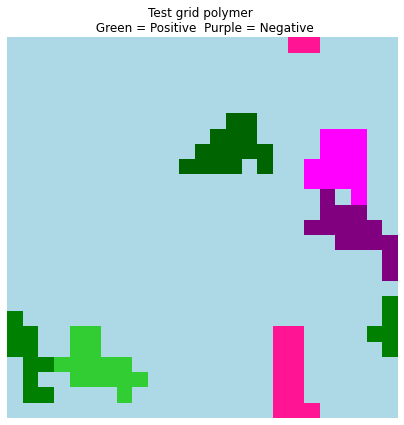

In [28]:
# Konstanter
Ns = 30000
N  = 25
L  = 15
M  = 3      # OBS Antall polymerer med samme ladning
T  = 200

grid_poly = create_grid_multivalency(N,M,L)
move = rigid_move

#Plott før av originalt polymer
f = plt.figure(figsize=(7,7))
#M = 3 --> 7 farger
levels = [-3,-2,-1,0,1,2,3,10]
colors = ["purple","magenta","deeppink","lightblue","darkgreen","limegreen","green"]
cmap1, norm1 = from_levels_and_colors(levels,colors)
    
plt.title("Test grid polymer \n Green = Positive  Purple = Negative")
plt.axis('off')
plt.pcolormesh(grid_poly[::-1],cmap = cmap1,norm = norm1)

In [29]:
grid_rigid_move, energy_rigid = Monte_Carlo_mult(Ns, N, M, T,grid_poly,move)

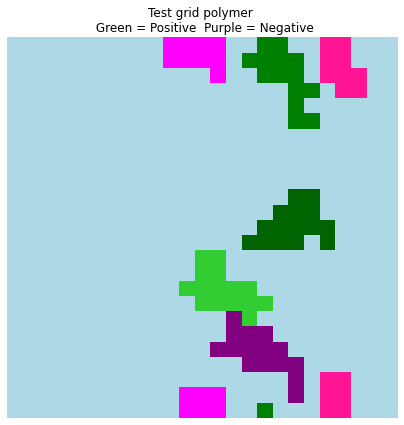

In [30]:
#Plott aav polymer etter simulering
f = plt.figure(figsize=(7,7))
#M = 3 --> 7 farger
levels = [-3,-2,-1,0,1,2,3,10]
colors = ["purple","magenta","deeppink","lightblue","darkgreen","limegreen","green"]
cmap1, norm1 = from_levels_and_colors(levels,colors)
    
plt.title("Test grid polymer \n Green = Positive  Purple = Negative")
plt.axis('off')
plt.pcolormesh(grid_rigid_move[::-1],cmap = cmap1,norm = norm1)

#### Drøfting av resultater

Dersom vi sammenligner systemet før start og etter kjøring ser vi for det første at alle polymerer har bevart form. Dette skyldes at et flytt som deformerer polymeren ikke er tillatt. I tillegg observerer vi at det siste systemet er mye mer energigunstig enn det opprinnelige systemet.

I det opprinnelige systemet ser vi i to tilfeller at polymerer av lik ladning berøre hverandre. Dette gir et positivt energi bidrag, som fra et fysisk perspektiv vil føre til en frastøtning. Dette er ikke energigunstig, da selv bare en splittelse av disse to vil føre til en negativ energidifferanse, som er mer sannsynlig. 

I det nye systemet ser vi ingen kontakt mellom polymerer av lik ladning, som stemmer overens med våre forventninger. I tillegg har vi ett tilfelle hvor to polymerer berører hverandre i to punkter. Dette gir en negativ energi, og er svært energi gunstig! Med andre ord ser vi tydelige tendenser til at systemet har gått mot en lavere energitilstand.

---

Kjøretiden for denne simulasjonen er betraktelig mye lavere enn for systemene i oppgave 1. Dette skyldes muligheten for et polymer til å bevege seg. For at et monomer skal kunne bevege seg, kreves det bare en ledig naborute for at det skal være mulig, men det samme gjelder ikke for rigid move flyttet.

For polymersystemet når vi bruker rigid move, så er polymeren svært avhengig av god plass rundt seg for at et flytt skal kunne kjøres. Skal for eksempel en rett linje på N monomerer i et polymer, bevege seg i en ortogonal retning, må det være N ledige ruter for å gjøre flyttet. Når gridstørrelsen blir relativt lav i forhold til antallet polymerer og størrelsen av disse, minker flytte mulighetene betraktelig.

Ettersom at Monte Carlo koden sjekker om det har skjedd noe med grid'et før den avgjør om flyttet skal realiseres, får vi en lavere kjørtid. Antall mulige flytt minker betraktelig, og med dette minimerer vi og de relativt tidkrevende if, elif og else setningene.

### Oppgave 2e: Implementerasjon av Medium flexibility-move
### Oppgave 2f: Implementasjon av funksjon for å sjekke ødelagt polymer
#### 2e og 2f gjøres i parallell ettersom at 2f innebærer en endring av 2e

In [32]:
#Kan ikke Jitte denne pga at scipy ikke støttes av Numba
def check_broken_polymer(grid_old,grid_new,polymer_value):
    N = np.shape(grid_new)[0]
    position_polymer = np.argwhere(grid_new == polymer_value)
    empty_grid = np.zeros((N,N),dtype = np.dtype('i2'))
    for i in range(len(position_polymer)):
        rad,kolonne = position_polymer[i]
        empty_grid[rad,kolonne] = polymer_value
    labeled = label(empty_grid)[0]
    cluster = monomer_to_cluster(labeled)
    cluster_number_new = number_of_clusters(cluster)
    
    #Sjekker om det er mer enn ett cluster med samme polymer-verdi
    if cluster_number_new == 1:
        return grid_new
    
    else:
        return grid_old

In [33]:
def medium_flex_move(grid,direction,polymer_value):
    opposite_direction = [1,0,3,2] #Høyre,Venstre,opp,ned
    N = np.shape(grid)[0]
    grid_new = grid.copy()
    grid_without_polymer = grid.copy()
    polymer_position = np.argwhere(grid == polymer_value)
    
    for i in range(len(polymer_position)):
        grid_without_polymer[polymer_position[i][0],polymer_position[i][1]] = 0
        
    for i in range(len(polymer_position)):
        x,y = polymer_position[i]
        x_try,y_try = get_neighbors_coordinates(N,x,y)[direction]

        if grid_without_polymer[x_try,y_try] == 0:
            grid_without_polymer[x_try,y_try] = polymer_value
        else:
            while True:
                if grid_without_polymer[x,y] == polymer_value:
                    x,y = get_neighbors_coordinates(N,x,y)[opposite_direction[direction]]
                else:
                    grid_without_polymer[x,y] = polymer_value
                    break
    
    grid_out = check_broken_polymer(grid,grid_without_polymer,polymer_value)
    return grid_out #Returnerer input grid dersom ødelagt, og after_move gridet ellers

### Oppgave 2g: Monte Carlo med Medium flexibility-move

In [34]:
#OBS må fjerne jit på MC før denne kjøres, da label ikke er støttet av numba
#Bruker samme input-grid som for rigid_move simulasjonen
Ns = 30000
N  = 25
L  = 15
M  = 3
T  = 200

grid_medium_flex = grid_poly #Samme grid som fra 2d
grid_sim_medium_flex, energy_medium_flex = Monte_Carlo_mult(Ns, N, M, T,grid_medium_flex,medium_flex_move)

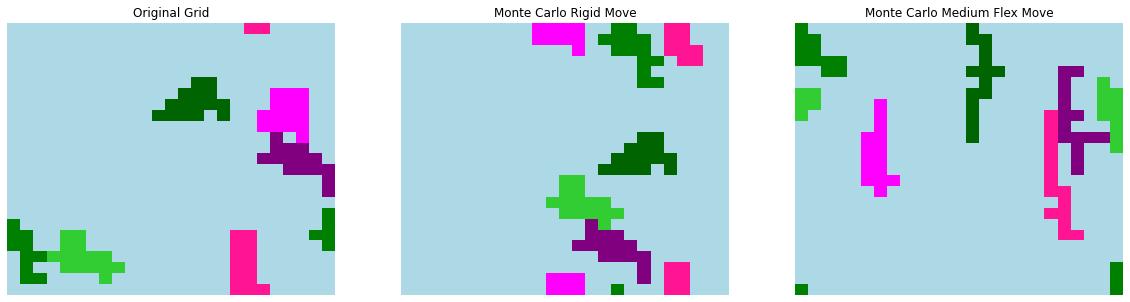

In [35]:
#Sammenligner de to ulike systemene for MonteCarlo simulasjon av samme grid

f = plt.figure(figsize=(20,5))
ax_original = f.add_subplot(131)
ax_rigid = f.add_subplot(132)
ax_medium = f.add_subplot(133)

ax_original.axis('off')
ax_rigid.axis('off')
ax_medium.axis('off')

#M = 3 --> 7 farger
levels = [-3,-2,-1,0,1,2,3,10]
colors = ["purple","magenta","deeppink","lightblue","darkgreen","limegreen","green"]
cmap1, norm1 = from_levels_and_colors(levels,colors)
    
ax_original.set_title("Original Grid")
ax_rigid.set_title("Monte Carlo Rigid Move")
ax_medium.set_title("Monte Carlo Medium Flex Move")

ax_original.pcolormesh(grid_poly[::-1],cmap = cmap1,norm = norm1)
ax_rigid.pcolormesh(grid_rigid_move[::-1],cmap = cmap1,norm = norm1)
ax_medium.pcolormesh(grid_sim_medium_flex[::-1],cmap = cmap1,norm = norm1)


#### Drøfting av resultater: Colormesh
Vi ser tydelige forskjeller i sammenligningen av systemene. Det hersker ikke tvil om at det har skjedd en endring. Hvordan systemet så ut for rigid move, ble diskutert i 2d. Ser vi derimot på medium flex move kjøringen ser vi helt andre tendenser.

For det første er det åpenbart at det har skjedd flytt hvor polymeren har hatt begrenset rom, dette ser vi på utstrekningen til polymerene. På samme måte som for rigid move, har polymerene prøvd å oppnå en lavere energitilstand. Det kan se ut til at de negative polymerene har "kilt" seg litt fast på høyre side av colormesh'en for medium flex move, dette har resultert i en positiv energi, men fortsatt lavere enn starttilstanden. 

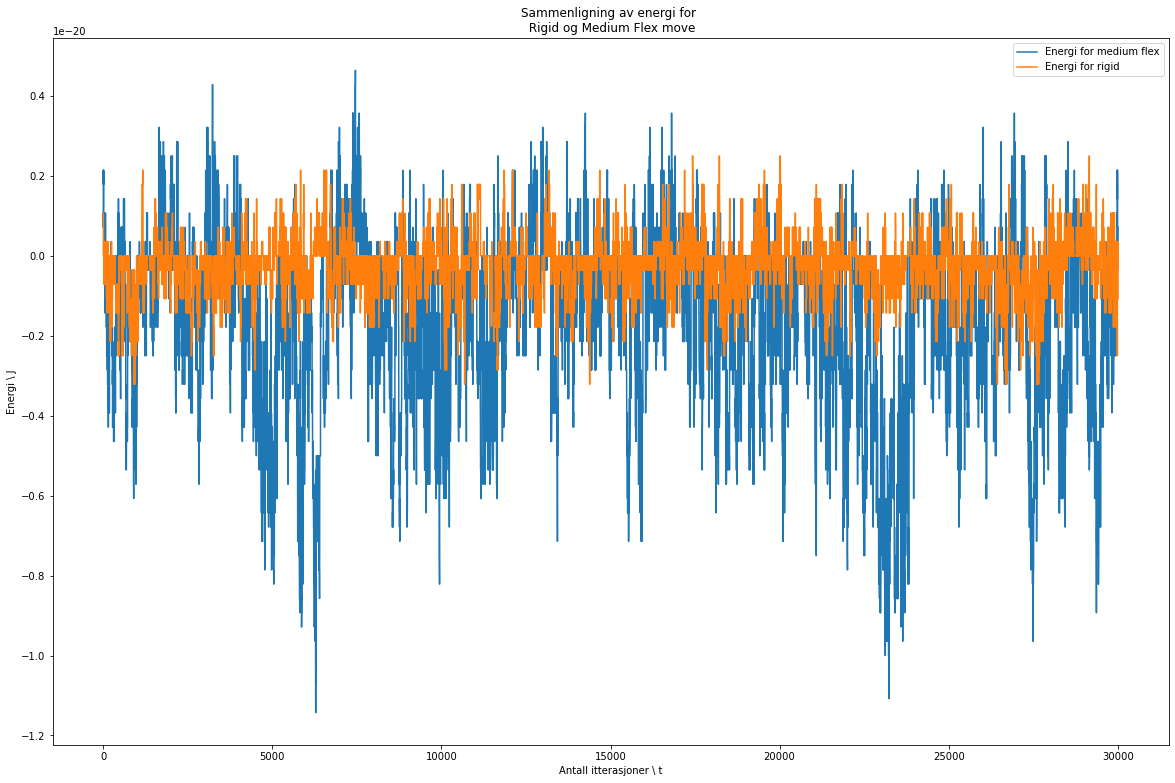

In [36]:
t = np.linspace(0,Ns,Ns+1)

plt.figure(figsize = (20,13))

plt.title("Sammenligning av energi for \n Rigid og Medium Flex move")
plt.xlabel("Antall itterasjoner \ t")
plt.ylabel("Energi \ J")

plt.plot(t,energy_medium_flex, label = "Energi for medium flex")
plt.plot(t,energy_rigid, label = "Energi for rigid")

plt.legend()
plt.show()

#### Drøfting av resultater: Energi plot
På energiplottet ser det svært rotete ut. Vi ser ikke like tydelig konvergensen vi så i 1f. Dette skyldes sannsynligvis mangelen på plass. For et monomer system oppsøker negative og positive monomerer hverandre, men dette er mye vanskeligere for et polymersystem. Det er nok dette som fører til den intense fluktueringen i energi for begge systemene, men vi ser en mye tydeligere amplitude for fluktueringen til medium flex move. Dette skyldes trolig at positive polymerer skal gli langs de negative polymerene. Dette vil være energi gunstig, og er trolig det vi ser som trend.


### Oppgave 2h: Stor-skala Monte Carlo-simulasjon for polymer-system
#### Forventningsverdi av cluster-størrelse og antall clusters
På samme vis som i 1h benytter vi oss av Monte Carlo algoritmen for å estimere forventningsverdier til systemet. Cluster-størrelse og antall clusters er for et gitt system svært like, men omvendt proposjonale med hverandre. 

Gjennomsnittlig clusterstørrelse vil være summen av alle clusterstørrelsene dividert med antall clustere. I realiteten blir dette 2ML/m , med 2M som totalt antall polymerer på grid, L som antall monomerer i ett polymer og m som antall cluster.

In [37]:
#Simulasjonsparametre
T       = 300
t_r     = 1000
N       = 30
M       = 5
L_vals  = np.linspace(3,39,13,dtype = np.dtype('i2'))
move    = medium_flex_move
t_equil = 10000 #OOBS !?!?
n       = 3

In [38]:
def simulasjon2():
    d_L = np.zeros(13,dtype = np.dtype('f'))
    m = np.zeros(13,dtype = np.dtype('f')) 
    for i in range(13):
        temp_m = 0
        temp_d = 0
        
        grid = create_grid_multivalency(N,M,L_vals[i])        
        grid_new = Monte_Carlo_mult(t_equil, N, M, T,grid,move)[0] #Grid etter antatt equil
      
        cluster_count = number_of_clusters(monomer_to_cluster(grid_new)) #Gir antallet clusters
        temp_m += cluster_count
        temp_d += 2*M/cluster_count #Obs: egt 2*M*L/(L*cluster_count), men L forkortes
        for j in range(n):
            grid_new = Monte_Carlo_mult(t_equil, N, M, T,grid_new,move)[0]

            cluster_count = number_of_clusters(monomer_to_cluster(grid_new)) #Gir antallet clusters
            temp_m += cluster_count
            temp_d += 2*M/cluster_count
            

        m[i] = temp_m/(n+1) #Gjennomsnittlig antall clusters
        d_L[i] = temp_d/(n+1)
        
    return m,d_L

In [39]:
m1,d_L1 = simulasjon2()

In [40]:
m2,d_L2 = simulasjon2()

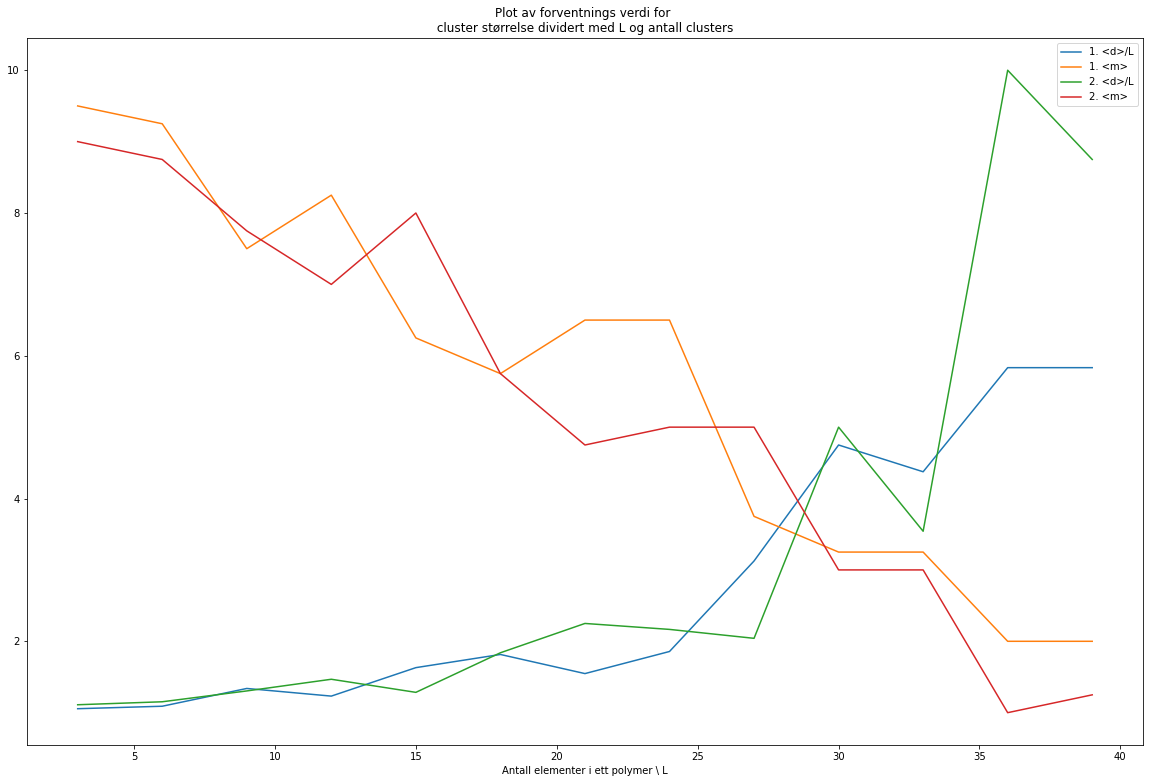

In [43]:
plt.figure(figsize=(20,13))

plt.title("Plot av forventnings verdi for \n cluster størrelse dividert med L og antall clusters ")
plt.xlabel("Antall elementer i ett polymer \ L")

plt.plot(L_vals,d_L1,label = "1. <d>/L")
plt.plot(L_vals,m1,label = "1. <m>")
plt.plot(L_vals,d_L2,label = "2. <d>/L")
plt.plot(L_vals,m2,label = "2. <m>")

plt.legend()
plt.show()

#### Drøfting av resultater:

Dessverre fikk vi ikke brukt Numba sin Jit på koden for 2g og 2h. Dette førte til at vi måtte begrense antall itterasjoner og antall målinger for å presse ned kjørtiden. På grunn av at vi ser på polymerer er det nok ikke urimelig at vi har fått en viss konvergens etter 10 000 itterasjoner, men er ikke umulig at denne verdien ble litt for lav. Det samme gjelder antall målinger (n+1). Her endte vi opp med å velge n = 3, som burde gi et respektabelt resultat, men vi kunne gjerne ha hatt flere for sikkerhetsskyld. Alt i alt endte vi med en kjørtid på 23 minutter for de to simulasjonene i 2h, utvilsomt ville vi kunne redusert denne betraktelig om vi kunne brukt Numba Jit på simulasjonen.

Resultatene ser svært "hakkete" og urolige ut, antakelig på grunn av lavt antall målinger. Utover dette ser resultatene rimelige ut. De to ulike simulasjonene går hverandre hånd-i-hånd, noe som styrker opp om at dette ikke bare var tilfeldigheter. Vi ser greit at grafene er omvendt proposjonale med hverandre, som var forventet.

Dersom vi hadde byttet til rigid move istede for medium flex, ville vi nok sett at antallet clusters ville økt. Dette skyldes medium flex realiserer flere flytt, og kan med det "slange" seg rundt de andre polymerene, dette lar seg ikke gjøre med rigid move.


Vi tenker at for lave verdier av L, så vil det være mye større områder å bevege seg på. Dette kan resultere i at antall clusters er høyere, da det er mange flere posisjoner på grid'et med løsning. Dette fører til at vi ikke nødvendigvis opplever at polymerene slanger seg rundt hverandre, da de har mye større plass å bevege seg på.

Dersom vi hadde hatt temperatur som en variabel, ville vi nok sedd store forskjeller i dannelse og ødeleggese av aggregatformering. På samme måte som i oppgave 1, vil høyere temperaturer føre til at et energiugunstig flytt kan realiseres. Dette ville trolig ført til at vi kunne fått store aggregater ved høye temperaturer, da det ikke lengre vil være usannsynlig at polymerer av lik ladning vil henge sammen.

## Konklusjon
For å oppsummere har prosjektet vært en stor suksess. Resultatene våre sto til forventningene og passer godt med teorien. Monte Carlo algoritmene konvergerte i alle tilfeller, og vi støtte ikke på noen uforventede problemer vi ikke klarte å løse. Plottene våre tydeliggjorde sammenhenger og viktigheten av temperatur i et biologisk system.